<h1 style ="font-size:3rem;color:orange;"> CNN - Image Classifier </h1>


## Import the library


In [1]:
#Python standard library
import os

#PyTorch
import torch    #(Conv2d, Linear, ReLU), loss functions (CrossEntropyLoss)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

#Torchvision
from torchvision import datasets, transforms
import torchvision.models as models

#numeric data
import numpy as np
import matplotlib.pyplot as plt 

#Pyhthon Images library
from PIL import Image   

#Evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support
import time


### Device Configuration (CPU / GPU)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available () else "cpu")

print("Using device: \n", device)  #if GPU available, model runs fast

Using device: 
 cpu


## Transforms (Normalization and Augmentation)


#### TRAIN TRANSFORM


In [3]:
image_size=64  # 64, used fro simple models like lightweight, 128 used for the pretrained model 0r 150, 224
               # (height, weight) = (64 x 64)

train_transform=transforms.Compose([      #.compose => resize the raw images, convert to tensor, normalize
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.05,0.1)),
    #transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(
        brightness=0.05,
        contrast=0.05,
        saturation=0.05),
    transforms.ToTensor(),   # to convert the PIL images to tensor
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #RGB channels  - adjusts the range of pixel values  (Larger and more varied images → better generalization.)
])

print(train_transform)

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    GaussianBlur(kernel_size=(3, 3), sigma=(0.05, 0.1))
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.95, 1.05), contrast=(0.95, 1.05), saturation=(0.95, 1.05), hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


#### TEST TRANSFORM


In [4]:
test_transform=transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),   # to convert the PIL images to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  #RGB channels
])

print(test_transform)

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


## Load the DataSet


In [5]:
print(current_dir := os.getcwd())

# Print model parameters
def print_named_params(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.numel()}")


def load_filepaths(target_dir):
    paths = []
    files = os.listdir(target_dir)
    for file in files:
        paths.append(f"{target_dir}/{file}")
    return paths

def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    return np.array(filepaths), torch.tensor(encoded_labels)

def load_images(filepaths, train=True):
    transform = train_transform if train else test_transform
    tensor_list = []
  
    for item in filepaths:
        image = Image.open(item).convert("RGB")
        tensor_list.append(transform(image))
    return torch.stack(tensor_list)


C:\Users\ovcha\CA


### Define CNN Model - color images (RGB)


In [6]:
start_time = time.time()

class FruitCNN(nn.Module):
    def __init__(self):          # initialize the layers
        super(FruitCNN, self). __init__()

        self.conv1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)    # Convolutional layers

        self.conv2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)   # -> Output size=((Input size−Kernel size+2(Padding))/Stride)+1
        
        self.conv3=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        
        self.pool=nn.MaxPool2d(2,2)   # Max Pooling layer

        self.flatten_dim = 128 * 8 * 8

        # Dropout Layer
        self.dropout = nn.Dropout(p=0.3)  # to reduce overfitting
    
        # Fully Connected Layer
        self.fc1=nn.Linear(in_features=self.flatten_dim, out_features=512)  #in_features = output after the 3rd convolutional layer 
        self.fc2=nn.Linear(in_features=512, out_features=4)

        #Activation Layer
        self.relu=nn.ReLU()

    def forward(self, x):   # Apply convolution + ReLU + pooling
        x=self.conv1(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv3(x)
        x=self.relu(x)
        x=self.pool(x)
        
        x=x.view(x.size(0), -1)  #dynamic flatten

        # Fully Connected Layer
        x=self.fc1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.fc2(x)     #Output layer
        
        return x

### Training Loop


In [7]:
def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs  =20
  batch_size = 72

  model.train()
    
  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    # generates permutated values of 0 to total_samples
    permutation = torch.randperm(total_samples)

    batch_n = 0
    for i in range(0, total_samples, batch_size):
      batch_n += 1

      # extract an array of "batch_size" elements from 
      # the permutation array
      indices = permutation[i : i + batch_size]   #[0:64] - only 63 files will be used for train
      batch_inputs = load_images(filepaths[indices], train = True)
      batch_labels = labels[indices]

      # Forward pass: coyympute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_n
        
      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} "  +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy * 100:.1f}%")


### Testing Loop


In [8]:
def test(model, filepaths, labels):
    batch_size = 64    
    samples_tested = 0
    correct_preds = 0
    total_samples = len(filepaths)
    
    for i in range(0, total_samples, batch_size):
        batch_inputs = load_images(filepaths[i : i + batch_size], train = False)
        batch_labels = labels[i : i + batch_size]

        # Forward pass: compute predicted outputs
        outputs = model(batch_inputs)


        # Get probability-distributions
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, dim=1)

        # Determine accuracy
        samples_tested += len(batch_labels)
        correct_preds += torch.sum(preds == batch_labels)
        accuracy = correct_preds / float(samples_tested)

        print(f"{samples_tested}/{total_samples}):Test Accuracy={accuracy * 100:.1f}%")


### Instantiate the model, define the loss function and optimize


In [9]:
model = FruitCNN()

criterion=nn.CrossEntropyLoss()  # Loss Function
optimizer=optim.Adam(model.parameters(),lr= 0.001)

### Train Model


In [10]:
# Train the model 
dir_train = r"C:\Users\ovcha\OneDrive\Oviya Laptop\Project\CNN Image Classifier\Team Project\bhava_dataset\CA_Training_Dataset\Final copy\training dataset" 
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

Epoch 1 (72/875): Loss=1.38673, Accuracy=23.6%


C:\Users\ovcha\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 (144/875): Loss=1.97764, Accuracy=27.1%
Epoch 1 (216/875): Loss=1.76100, Accuracy=32.4%
Epoch 1 (288/875): Loss=1.66557, Accuracy=30.6%
Epoch 1 (360/875): Loss=1.60173, Accuracy=31.1%
Epoch 1 (432/875): Loss=1.56535, Accuracy=28.5%
Epoch 1 (504/875): Loss=1.52819, Accuracy=29.4%
Epoch 1 (576/875): Loss=1.50054, Accuracy=32.6%
Epoch 1 (648/875): Loss=1.47118, Accuracy=34.9%
Epoch 1 (720/875): Loss=1.44935, Accuracy=36.0%
Epoch 1 (792/875): Loss=1.42441, Accuracy=36.7%
Epoch 1 (864/875): Loss=1.39538, Accuracy=38.5%
Epoch 1 (875/875): Loss=1.36144, Accuracy=39.0%
Epoch 2 (72/875): Loss=0.98563, Accuracy=61.1%
Epoch 2 (144/875): Loss=0.86111, Accuracy=68.1%
Epoch 2 (216/875): Loss=0.88932, Accuracy=63.0%
Epoch 2 (288/875): Loss=0.85150, Accuracy=66.0%
Epoch 2 (360/875): Loss=0.84221, Accuracy=67.2%
Epoch 2 (432/875): Loss=0.82269, Accuracy=67.4%
Epoch 2 (504/875): Loss=0.81725, Accuracy=68.7%
Epoch 2 (576/875): Loss=0.85088, Accuracy=68.4%
Epoch 2 (648/875): Loss=0.84154, Accuracy

### Test Model


In [11]:
# Test the model
dir_test = r"C:\Users\ovcha\OneDrive\Oviya Laptop\Project\CNN Image Classifier\Team Project\ov model\data\test" 
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

60/60):Test Accuracy=93.3%


### Confusion Matrix



Classification Report:
              precision    recall  f1-score   support

       apple       0.90      1.00      0.95        19
      banana       1.00      0.83      0.91        18
      orange       0.90      1.00      0.95        18
       mixed       0.75      0.60      0.67         5

    accuracy                           0.92        60
   macro avg       0.89      0.86      0.87        60
weighted avg       0.92      0.92      0.91        60

Macro F1 Score: 0.8682814992025517
Confusion Matrix - CNN Image Classifier:
[[19  0  0  0]
 [ 1 15  1  1]
 [ 0  0 18  0]
 [ 1  0  1  3]]


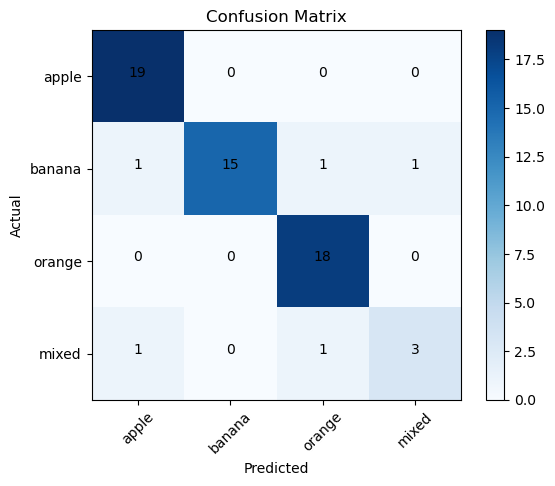

In [12]:
#Get all the predictions
all_preds=[]
names = ["apple","banana","orange","mixed"]

for img in load_images(filepaths):   
    out = model(img.unsqueeze(0))    
    all_preds.append(out.argmax(1).item())

# Classification report (precision, recall, f1, support)
print("\nClassification Report:")
print(classification_report(labels, all_preds, target_names=names))

# Macro F1 score
macro_f1 = f1_score(labels, all_preds, average='macro')
print("Macro F1 Score:", macro_f1)

#confusion matrix -> compute
cm= confusion_matrix(labels, all_preds)
print("Confusion Matrix - CNN Image Classifier:")
print(cm) 
plt.xticks(range(4), names, rotation=45)
plt.yticks(range(4), names)
plt.imshow(cm, cmap="Blues")

# numbers inside
for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i,j], ha="center", color="black")
        
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Plot the graph


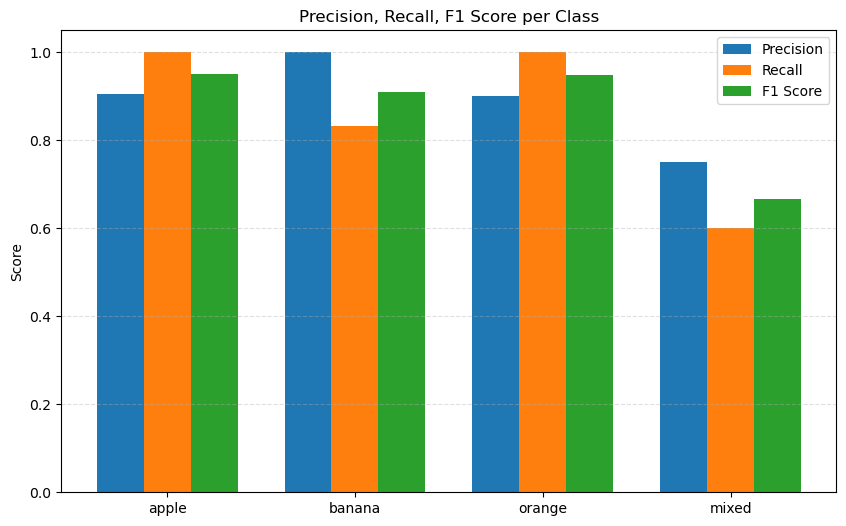

In [13]:
precision, recall, f1, support = precision_recall_fscore_support(labels, all_preds)

x = np.arange(len(names))  # label positions
width = 0.25               # width of bars

plt.figure(figsize=(10, 6))

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xticks(x, names)
plt.ylabel("Score")
plt.title("Precision, Recall, F1 Score per Class")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

In [14]:
# Time calculation for model training

end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")


Execution time: 570.9675121307373 seconds
